# ASSIGNMENT 2 QUESTION 3 COMPUTATIONAL FINANCE

PART A: Data retrieval:

In [64]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# Set up the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [9]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    # Amsterdam area (you can change)
    "latitude": 52.37,
    "longitude": 4.89,
    "start_date": "2020-08-10",
    "end_date": "2024-08-23",
    "hourly": "temperature_2m",
    "daily": "temperature_2m_mean"
}

responses = openmeteo.weather_api(url, params=params)

In [11]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Elevation {response.Elevation()} masl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Elevation 11.0 masl
Timezone None None
Timezone difference to GMT+0 0 s


In [34]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature = hourly.Variables(0).ValuesAsNumpy()
hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )
}
hourly_data["temperature_2m"] = hourly_temperature
hourly_dataframe = pd.DataFrame(data=hourly_data)
#print(hourly_dataframe)

In [33]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature = daily.Variables(0).ValuesAsNumpy()
daily_data = {
    "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )
}
daily_data["temperature_2m_mean"] = daily_temperature
daily_dataframe = pd.DataFrame(data=daily_data)
daily_dataframe = daily_dataframe.set_index(pd.to_datetime(daily_dataframe['date'])).dropna()

print(daily_dataframe.head())

                                               date  temperature_2m_mean
date                                                                    
2021-03-23 00:00:00+00:00 2021-03-23 00:00:00+00:00             6.909750
2021-03-24 00:00:00+00:00 2021-03-24 00:00:00+00:00             7.820167
2021-03-25 00:00:00+00:00 2021-03-25 00:00:00+00:00             8.422250
2021-03-26 00:00:00+00:00 2021-03-26 00:00:00+00:00             9.863917
2021-03-27 00:00:00+00:00 2021-03-27 00:00:00+00:00             5.895168


PART B:

TASK 1: EDA

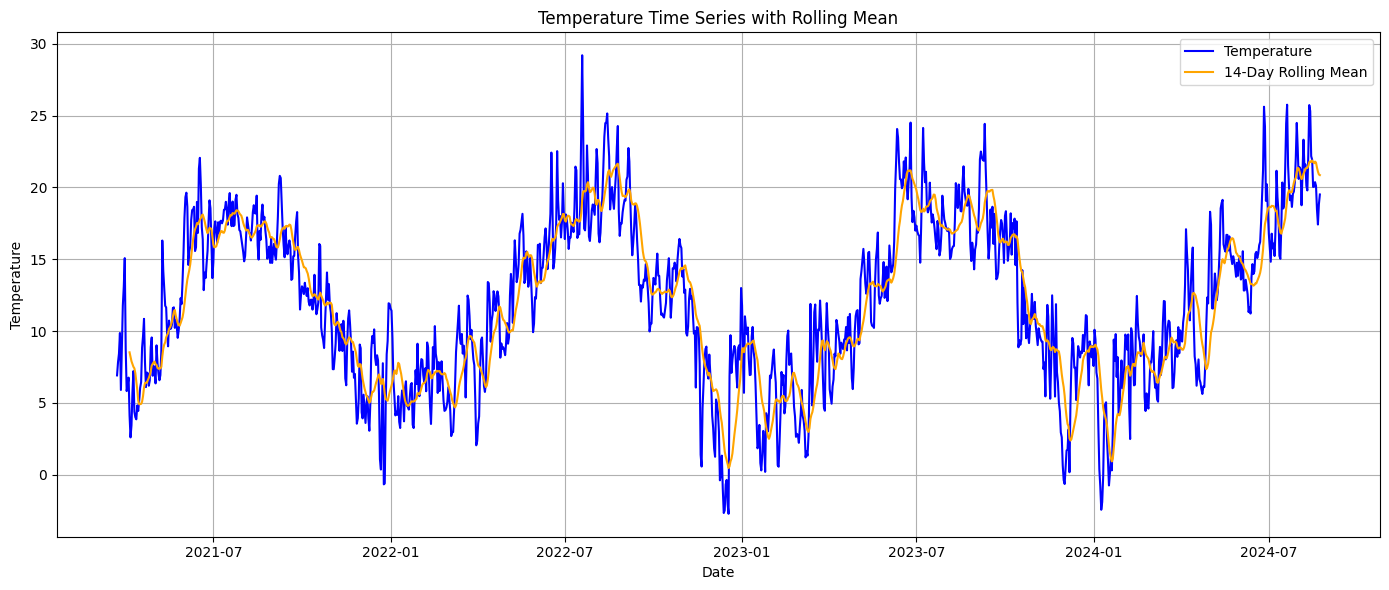

In [41]:
#Set the rolling window to 7 days
rolling_window = 14
daily_dataframe['rolling_mean'] = daily_dataframe['temperature_2m_mean'].rolling(window=rolling_window).mean()
daily_dataframe['rolling_variance'] = daily_dataframe['temperature_2m_mean'].rolling(window=rolling_window).var()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_dataframe.index, daily_dataframe['temperature_2m_mean'], label='Temperature', color='blue')
plt.plot(daily_dataframe.index, daily_dataframe['rolling_mean'], label=f'{rolling_window}-Day Rolling Mean', color='orange')
#plt.plot(daily_dataframe.index, daily_dataframe['rolling_variance'], label=f'{rolling_window}-Day Rolling Variance', color='green')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Time Series with Rolling Mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

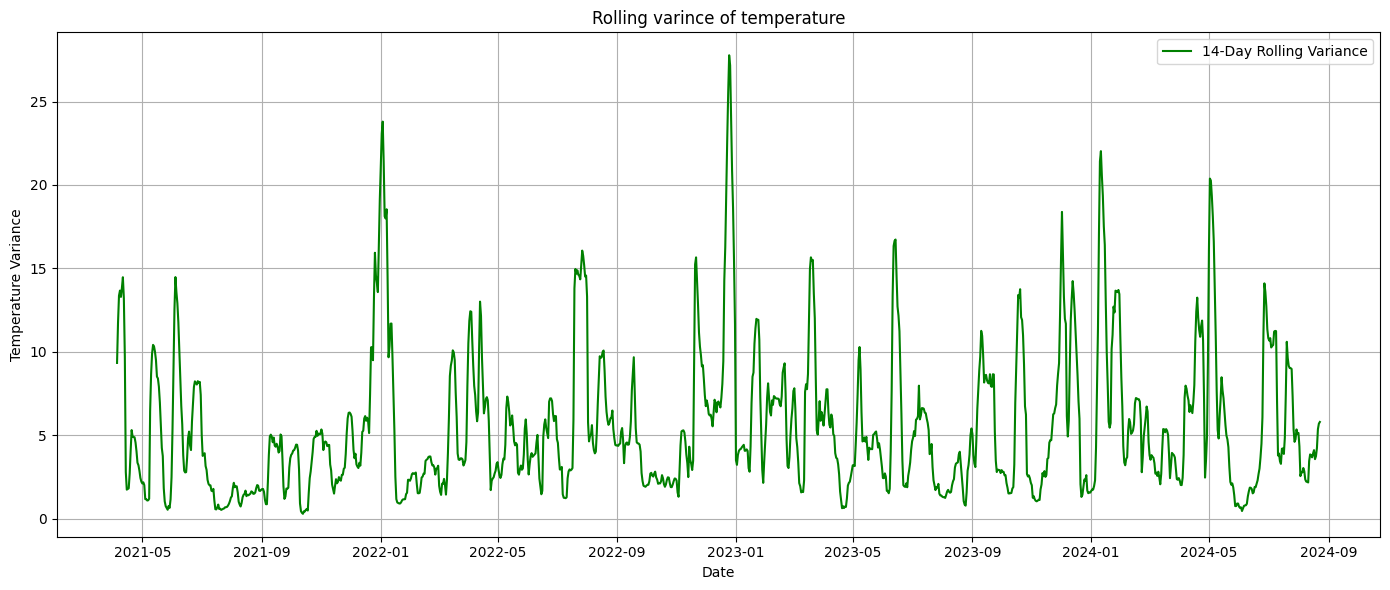

In [42]:
# Plot
plt.figure(figsize=(14, 6))
#plt.plot(daily_dataframe.index, daily_dataframe['temperature_2m_mean'], label='Temperature', color='blue')
#plt.plot(daily_dataframe.index, daily_dataframe['rolling_mean'], label=f'{rolling_window}-Day Rolling Mean', color='orange')
plt.plot(daily_dataframe.index, daily_dataframe['rolling_variance'], label=f'{rolling_window}-Day Rolling Variance', color='green')

plt.xlabel('Date')
plt.ylabel('Temperature Variance')
plt.title('Rolling varince of temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

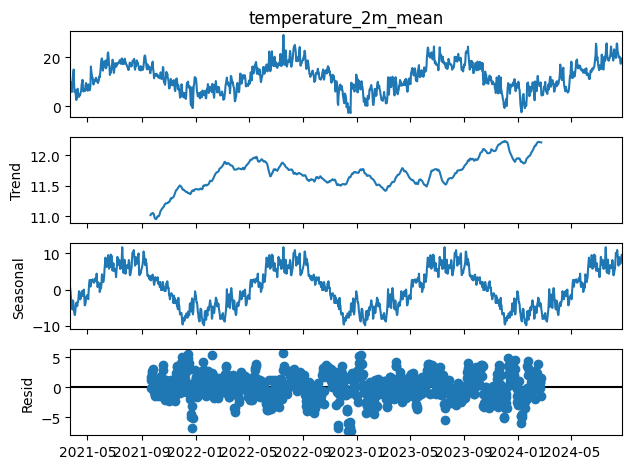

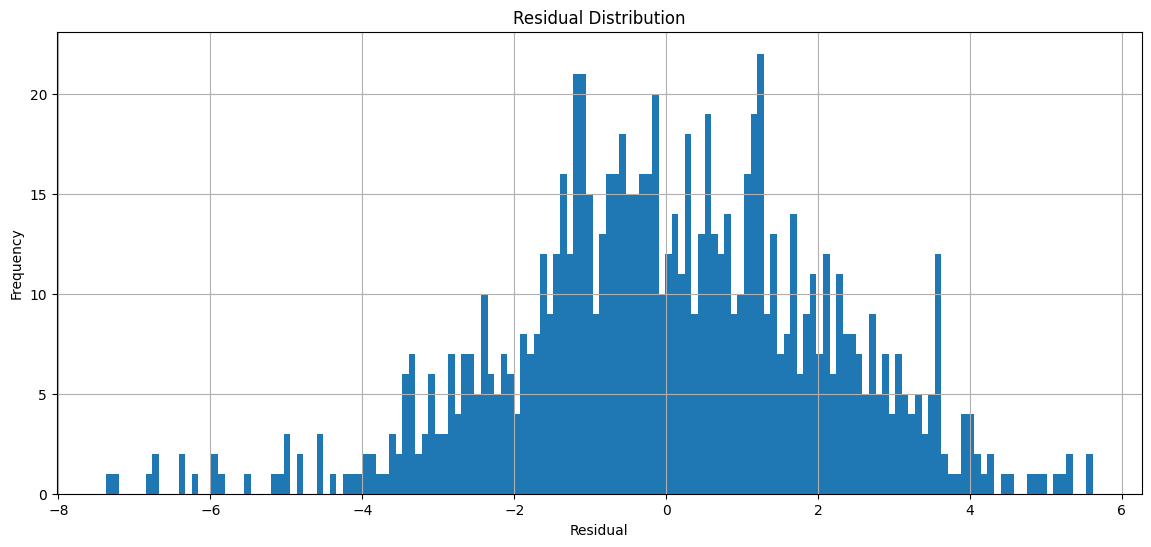

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (assume 365 days per year for annual seasonality)
decompose_result = seasonal_decompose(
    daily_dataframe['temperature_2m_mean'], 
    model='additive', 
    period=365
)

# Extract components
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

# Plot decomposition
plt.figure(figsize=(14, 6))
decompose_result.plot()
plt.show()

# Plot residual distribution
plt.figure(figsize=(14, 6))
plt.hist(residual.dropna(), bins=150)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

TASK 2: RESIDUAL ANALYSIS

In [56]:
residualsss = residual.dropna()

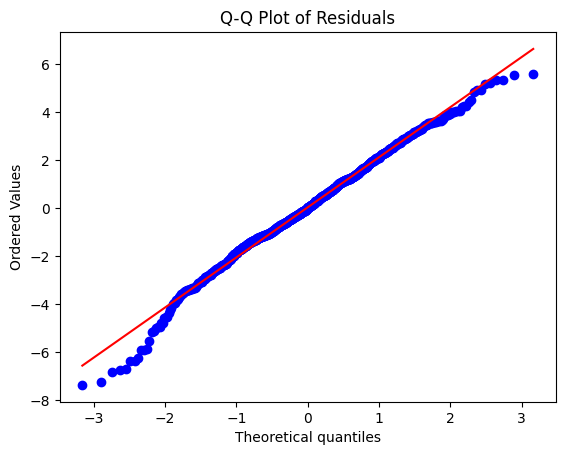

In [61]:
import scipy.stats as stats

stats.probplot(residualsss, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

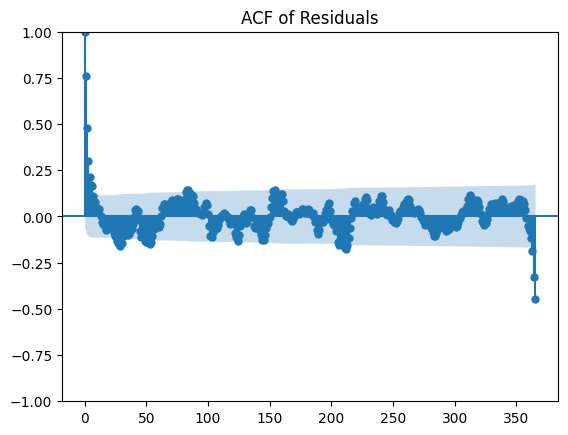

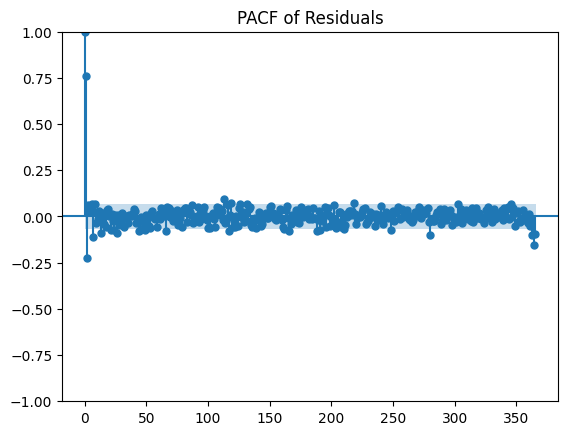

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residualsss, lags=365)
plt.title("ACF of Residuals")
plt.show()

# PACF plot
plot_pacf(residualsss, lags=365)
plt.title("PACF of Residuals")
plt.show()

In [63]:
#Dickey-Fuller test for stationarity of the residuals:

from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(residualsss)

# Extract and print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Used lags:", result[2])
print("Number of observations:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -7.935542350382913
p-value: 3.421491021964388e-12
Used lags: 7
Number of observations: 878
Critical Values:
   1%: -3.437819842246547
   5%: -2.8648374649929753
   10%: -2.5685258078777093


It follows that we reject the null--hypothesis of a unit root.

# =====================================================================================================================================

PART C: Fitting the Model under P

TASK 1: Deterministic Model Fitting

TASK 2: Autoregressive Modeling of Residuals 

??INCLUDE FOURIER APPROXIMATION??

In [68]:
from scipy.optimize import curve_fit

# Define the deterministic model function
def model_fit(x, a, b, alpha, theta):
    omega = 2 * np.pi / 365.25
    return a + b * x + alpha * np.sin(omega * x + theta)

# Convert dates to ordinal numbers and fit model
first_ord = daily_dataframe.index[0].toordinal()
xdata = np.array([date.toordinal() - first_ord for date in daily_dataframe.index])
ydata = daily_dataframe['temperature_2m_mean']

# Fit the model
params_all, cov = curve_fit(model_fit, xdata, ydata, method='lm')

# Store results
daily_dataframe['model'] = model_fit(xdata, *params_all)
daily_dataframe['residuals'] = daily_dataframe['temperature_2m_mean'] - daily_dataframe['model']

print("Estimated parameters:", params_all)

Estimated parameters: [ 1.06638907e+01  1.52371298e-03  6.96298289e+00 -6.90505160e+00]


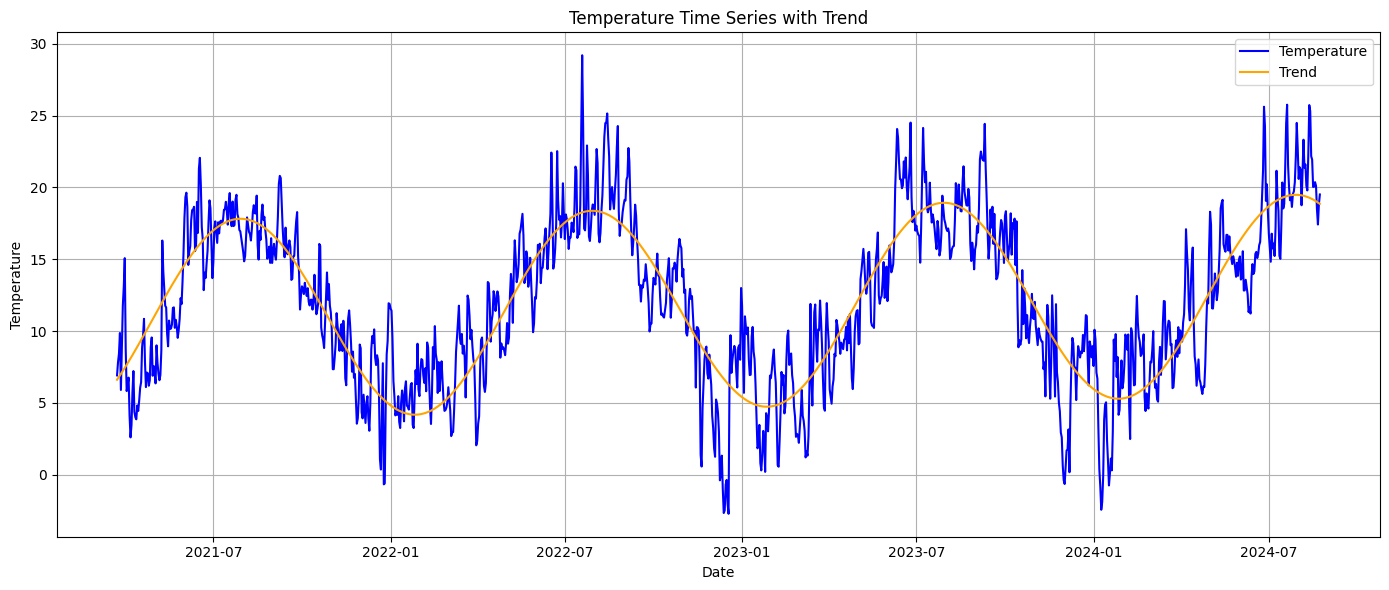

In [72]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_dataframe.index, daily_dataframe['temperature_2m_mean'], label='Temperature', color='blue')
plt.plot(daily_dataframe.index, daily_dataframe['model'], label='Trend', color='orange')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Time Series with Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

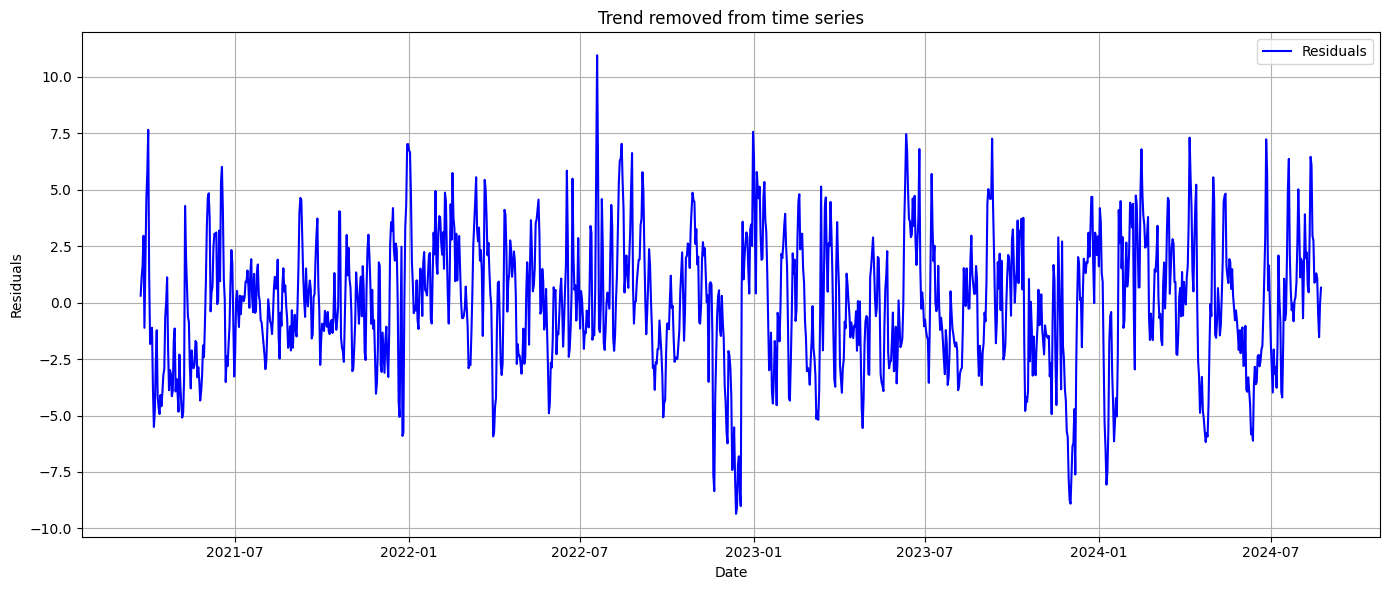

In [74]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_dataframe.index, daily_dataframe['residuals'], label='Residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Trend removed from time series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We now fit an AR-model to the residuals. The AR order is based on the number of significant lags in the PACF.

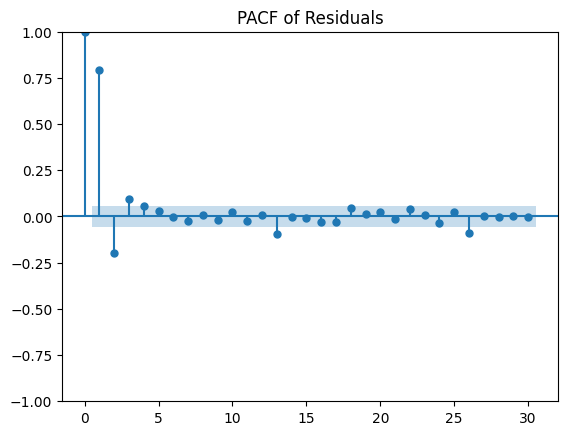

In [76]:
# PACF plot
plot_pacf(daily_dataframe['residuals'], lags=30)
plt.title("PACF of Residuals")
plt.show()

This suggests the order should be 3 or 4, we confirm this with the BIC:

In [81]:
from statsmodels.tsa.ar_model import AutoReg

bic_values = []
max_p = 10  # Test up to AR(10)
for p in range(1, max_p + 1):
    model = AutoReg(daily_dataframe['residuals'], lags=p).fit()
    bic_values.append(model.bic)

optimal_p = np.argmin(bic_values) + 1  # +1 because Python is 0-indexed
print(f"Optimal AR order (BIC): p = {optimal_p}")

Optimal AR order (BIC): p = 5


C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

We proceed with 4 lags anyways.